<a href="https://colab.research.google.com/github/sriksmachi/rebi/blob/main/obstacle_detection_for_home_cleaning_robots_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import json
import argparse
import numpy as np
import random
import math
import csv
import skimage.io as io
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.parse
from IPython.display import Image, clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data = '/content/drive/MyDrive/rbei/train_data/syn_images/'

In [19]:
!ln -s /content/drive/MyDrive/bosch_model/ workspace

In [6]:
print(len([name for name in os.listdir(train_data)]))

5660


In [7]:
# Code for cleaning up augmented files during training

import os
import tqdm
for name in tqdm.tqdm(os.listdir(train_data)):
  if ('aug_' in name):
    os.remove(os.path.join(train_data, name))

100%|██████████| 5660/5660 [00:00<00:00, 413203.15it/s]


In [8]:
for name in os.listdir(train_data):
 if (('.jpg' in name) and ('%' in name)):
    print(f'renaming..{name}')
    os.rename(train_data + name, train_data + str(name).replace('%20',''))

In [9]:
import pandas as pd
if os.path.exists(train_data + 'training_data.csv'):
  ds = pd.read_csv(os.path.join(train_data, 'training_data.csv'))
else:
  list_dt = []
  for name in os.listdir(train_data):
    if ('.csv' in name):
      dt = pd.read_csv(os.path.join(train_data, name))
      list_dt.append(dt)

  ds  = pd.concat(list_dt, axis=0, ignore_index=True)

In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8508 entries, 0 to 8507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     8508 non-null   object 
 1   xmin      8508 non-null   float64
 2   ymin      8508 non-null   float64
 3   xmax      8508 non-null   float64
 4   ymax      8508 non-null   float64
 5   label     8508 non-null   object 
 6   w         8508 non-null   float64
 7   h         8508 non-null   float64
 8   x_center  8508 non-null   float64
 9   y_center  8508 non-null   float64
dtypes: float64(8), object(2)
memory usage: 664.8+ KB


In [11]:
ds.head()

,image,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center
0,video-5-ezgif-frame-021(10).jpg,2.646451,0.0,638.676775,549.788603,door,636.030324,549.788603,320.661613,274.894301
1,video-5-ezgif-frame-021(101).jpg,125.265334,0.0,1117.684356,596.553309,door,992.419022,596.553309,621.474845,298.276654
2,video-5-ezgif-frame-021(1).jpg,188.780152,0.0,680.137836,450.965074,door,491.357684,450.965074,434.458994,225.482537
3,video-5-ezgif-frame-021(100).jpg,100.565128,0.0,1099.159201,598.318015,door,998.594074,598.318015,599.862164,299.159007
4,video-5-ezgif-frame-021(102).jpg,159.669194,0.0,1118.566506,626.553309,door,958.897312,626.553309,639.117850,313.276654


In [12]:
# removing % from the image name as we did in the files above. 
ds['image'] = ds['image'].apply(lambda x: str(x).replace('%20',''))

In [13]:
# Validate if every Image is atleast tagged once. 
count = -1 # because we have a csv file
filescount = 0
for file in os.listdir(train_data):
  filescount += 1
  if len(ds[(ds.image==file)]) == 0:
    print(f'file name...{file}')
    count += 1
    #os.remove(os.path.join(train_data, file))
print(f'{filescount} files found, {count} files untagged')
# filescount

file name...doors_tagging-export.csv
file name...sk_raw-export.csv
file name...train_data.csv
file name...rebi-export.csv
file name...test-export.csv
file name...syn_images
file name...workspace
file name...training_data.csv
file name...bosch_model
5660 files found, 8 files untagged


In [14]:
ds['w'] = ds.xmax - ds.xmin
ds['h'] = ds.ymax - ds.ymin
ds['x_center'] = (ds.xmax + ds.xmin)/2
ds['y_center'] = (ds.ymax + ds.ymin)/2

In [15]:
ds.label.unique()

array(['door', 'furniture', 'cable', 'garment'], dtype=object)

In [16]:
ds.loc[ds.label == 'doors', 'label'] = 'door'
ds.loc[ds.label == 'cables', 'label'] = 'cable'
ds.loc[ds.label == 'object', 'label'] = 'garment'
ds.label.unique()

array(['door', 'furniture', 'cable', 'garment'], dtype=object)

In [17]:
filename = os.path.join(train_data,'training_data.csv')
ds.to_csv(filename, index=None)
ds = pd.read_csv(filename)
ds.head()

,image,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center
0,video-5-ezgif-frame-021(10).jpg,2.646451,0.0,638.676775,549.788603,door,636.030324,549.788603,320.661613,274.894301
1,video-5-ezgif-frame-021(101).jpg,125.265334,0.0,1117.684356,596.553309,door,992.419022,596.553309,621.474845,298.276654
2,video-5-ezgif-frame-021(1).jpg,188.780152,0.0,680.137836,450.965074,door,491.357684,450.965074,434.458994,225.482537
3,video-5-ezgif-frame-021(100).jpg,100.565128,0.0,1099.159201,598.318015,door,998.594074,598.318015,599.862164,299.159007
4,video-5-ezgif-frame-021(102).jpg,159.669194,0.0,1118.566506,626.553309,door,958.897312,626.553309,639.117850,313.276654


In [20]:
%cd workspace/

/content/drive/MyDrive/bosch_model


In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15050, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15050 (delta 16), reused 34 (delta 14), pack-reused 15002
Receiving objects: 100% (15050/15050), 13.48 MiB | 2.14 MiB/s, done.
Resolving deltas: 100% (10215/10215), done.
Checking out files: 100% (2028/2028), done.


In [21]:
from urllib.parse import unquote
img_w, img_h, num_channels = (1280, 720, 3)
df = ds.copy()
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: str(x).split('.')[0])
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center,classes
0,video-5-ezgif-frame-021(10),2.646451,0.0,638.676775,549.788603,door,0.496899,0.763595,0.250517,0.381798,0
1,video-5-ezgif-frame-021(101),125.265334,0.0,1117.684356,596.553309,door,0.775327,0.828546,0.485527,0.414273,0
2,video-5-ezgif-frame-021(1),188.780152,0.0,680.137836,450.965074,door,0.383873,0.626340,0.339421,0.313170,0
3,video-5-ezgif-frame-021(100),100.565128,0.0,1099.159201,598.318015,door,0.780152,0.830997,0.468642,0.415499,0
4,video-5-ezgif-frame-021(102),159.669194,0.0,1118.566506,626.553309,door,0.749139,0.870213,0.499311,0.435106,0


In [22]:
df.loc[ds.label == 'door', 'classes'] = 0
df.loc[ds.label == 'furniture', 'classes'] = 1
df.loc[ds.label == 'cable', 'classes'] = 2
df.loc[ds.label == 'garment', 'classes'] = 3
df.classes.unique()

array([0, 1, 2, 3])

In [23]:
!ls

bad_label.list		      data	   results_tiny.log
bad.list		      dataset	   yolov4.conv.137
bosch_model		      obj.data	   yolov4-custom.cfg
chart.png		      obj.names    yolov4-tiny.conv.29
chart_yolov4-tiny-custom.png  results	   yolov4-tiny-custom.cfg
darknet			      results.log


(720, 1280, 3)

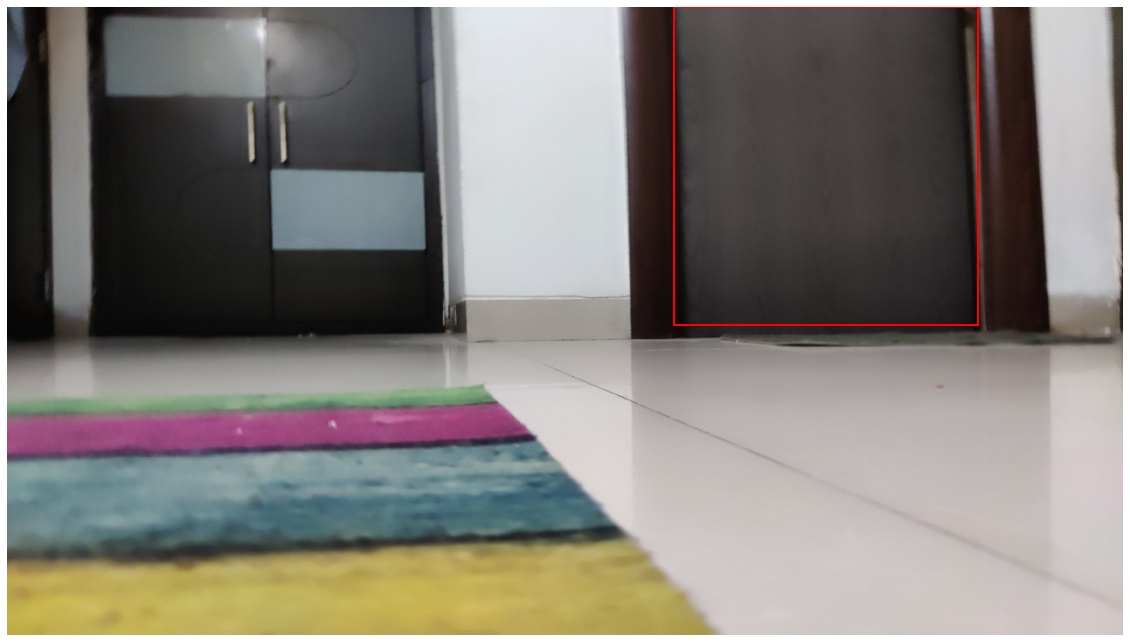

In [24]:
plt.figure(figsize=(20, 20))
I = io.imread(train_data + 'IMG_1621346939967.jpg')
foreground = I.copy()
plt.axis('off')
plt.imshow(foreground)
# x, y , w, h
plt.gca().add_patch(Rectangle((764,0),0.273*1280,0.506*720,linewidth=2,edgecolor='r',facecolor='none'))
plt.plot()
foreground.shape

In [26]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size = 0.1, shuffle=True, random_state=42)

In [27]:
df_train.head()

,image_id,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center,classes
5438,syn_img_3335,924.00000,0.0,1072.0000,364.000000,furniture,0.115625,0.505556,0.779687,0.252778,1
5039,syn_img_3079,189.00000,344.0,896.0000,481.000000,cable,0.552344,0.190278,0.423828,0.572917,2
7101,syn_img_4474,231.00000,316.0,1131.0000,554.000000,garment,0.703125,0.330556,0.532031,0.604167,3
61,video-5-ezgif-frame-021(17),73.21847,0.0,730.4204,470.376838,door,0.513439,0.653301,0.313921,0.326651,0
6180,syn_img_3825,553.00000,525.0,784.0000,683.000000,garment,0.180469,0.219444,0.522266,0.838889,3


In [28]:
training_data = '/train/'
validation_data = '/val/'
project_path = '.'

In [30]:
from tqdm.auto import tqdm
import shutil as sh

def process_data(df, df_type = 'train'):
  for name,mini in tqdm(df.groupby('image_id')):
    if df_type == 'validation':
      path2save = project_path + '/data/{}'.format(validation_data)
    else:
        path2save = project_path + '/data/{}'.format(training_data)

    # creating images folder for training
    if not os.path.exists(path2save):
        os.makedirs(path2save)
        
    if not os.path.exists(path2save + name + ".txt"):
      with open(path2save + name + ".txt", 'w+') as f:
          row = mini[['classes', 'x_center','y_center','w','h']].astype(str).values
          row = row.astype(str)
          for j in range(len(row)):
              text = ' '.join(row[j])
              f.write(text)
              f.write("\n")
      sh.copy("{}/{}.jpg".format(train_data,name), path2save + '/{}.jpg'.format(name)) 

In [31]:
process_data(df_train, 'train')
process_data(df_val, 'validation')

In [32]:
# Ensuring we at the right folder
!ls

bad_label.list		      data	   results_tiny.log
bad.list		      dataset	   yolov4.conv.137
bosch_model		      obj.data	   yolov4-custom.cfg
chart.png		      obj.names    yolov4-tiny.conv.29
chart_yolov4-tiny-custom.png  results	   yolov4-tiny-custom.cfg
darknet			      results.log


In [33]:
import glob, os

folderpath = 'data/'

if not os.path.exists('./data'):
  os.makedirs('./data')

# Create and/or truncate train.txt and test.txt
with open(folderpath + 'train.txt', 'w') as file_train:
  for pathAndFilename in glob.iglob(os.path.join(folderpath, 'train', "*.jpg")):
      file_train.write(pathAndFilename + "\n")

with open(folderpath + 'test.txt', 'w') as file_test:
  for pathAndFilename in glob.iglob(os.path.join(folderpath, 'val', "*.jpg")):
      file_test.write(pathAndFilename + "\n")

In [ ]:
# Copying the train test data to darknet folder
# !rm -r darknet/data
# !cp -r data darknet/

rm: cannot remove 'darknet/data': No such file or directory


In [34]:
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!make

/content/drive/MyDrive/bosch_model/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (itera

In [35]:
# cleanup some data in darknet and come back to root folder
# !rm -r cfg/
# !mkdir cfg
%cd ..
!ls

/content/drive/MyDrive/bosch_model
bad_label.list		      data	   results_tiny.log
bad.list		      dataset	   yolov4.conv.137
bosch_model		      obj.data	   yolov4-custom.cfg
chart.png		      obj.names    yolov4-tiny.conv.29
chart_yolov4-tiny-custom.png  results	   yolov4-tiny-custom.cfg
darknet			      results.log


In [ ]:
!cp yolov4-custom.cfg darknet/cfg/
!cp yolov4-tiny-custom.cfg darknet/cfg/

In [ ]:
# %cd doors/
!ls

bad.list		      dataset		yolov4.conv.137
chart.png		      obj.data		yolov4-custom.cfg
chart_yolov4-tiny-custom.png  obj.names		yolov4-tiny.conv.29
darknet			      results		yolov4-tiny-custom.cfg
data			      results_tiny.log


In [ ]:
# Tiny Training
!darknet/darknet detector train obj.data darknet/cfg/yolov4-tiny-custom.cfg yolov4-tiny.conv.29 -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000193, iou_loss = 0.000000, total_loss = 0.000193 
 total_bbox = 680885, rewritten_bbox = 0.073874 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.880193), count: 3, class_loss = 0.340467, iou_loss = 0.635265, total_loss = 0.975731 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000013, iou_loss = 0.000000, total_loss = 0.000013 
 total_bbox = 680888, rewritten_bbox = 0.073874 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.776960), count: 3, class_loss = 0.346909, iou_loss = 0.388024, total_loss = 0.734932 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.633356), count: 1, class_loss = 0.278458, iou_loss = 1.439404, total_loss = 1.717862 
 total_

In [ ]:
%cd ..

/content/drive/MyDrive/bosch_model


In [ ]:
# Full training
#!darknet/darknet detector train obj.data darknet/cfg/yolov4-custom.cfg yolov4.conv.137 -map -dont_show | tee results.log

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('chart_yolov4-custom.png')

AttributeError: ignored

## Test

Before running the below remember to change the 
batch > 1, subdivisions ->1 

In [ ]:
!ls

bad.list		      fold0	       training
chart.png		      obj.data	       yolov4.conv.137
chart_yolov4-tiny-custom.png  obj.names        yolov4-custom.cfg
darknet			      predictions.jpg  yolov4-tiny.conv.29
data			      results	       yolov4-tiny-custom.cfg


In [ ]:
!darknet/darknet detector test obj.data darknet/cfg/yolov4-custom.cfg results/yolov4-custom_best.weights darknet/data/val/video-1-frame-44.jpg -dont_show


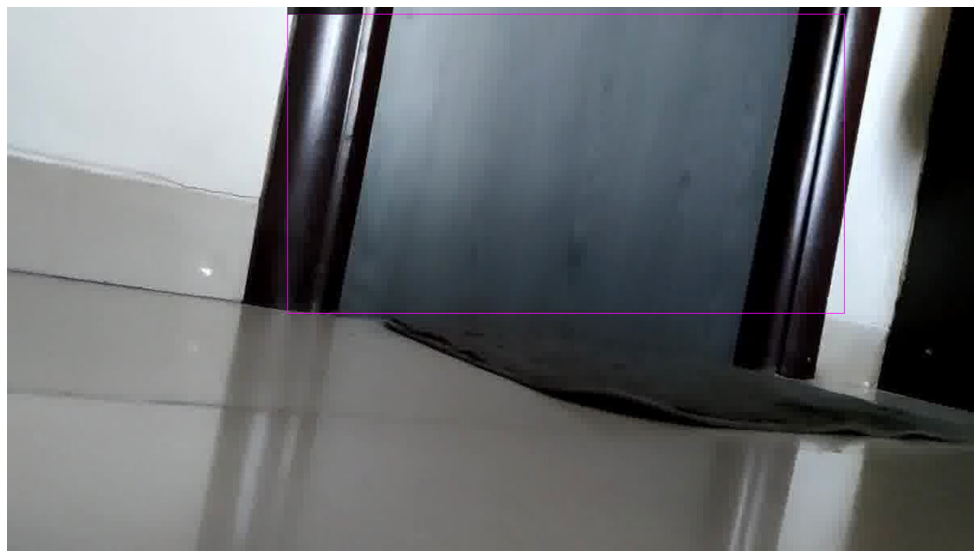

In [ ]:
imShow('predictions.jpg')